Нейронный перенос стиля с Pytorch
============================


In [1]:
%matplotlib inline
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

import numpy as np

**Загрузка изображений**

Нам понадобятся картинки стиля и контента, так что загрузим их.<br />
Чтобы упростить реализацию, начнем с контента и стиля одного размера. Затем мы масштабируем их до требуемых размеров выходного изображения.

Примеры изображений лежат в папке `Images` на гуглдиске


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("drive/MyDrive/Images/stylet_11.jpg") # style 1
style2_img = image_loader("drive/MyDrive/Images/fire.jpg") # style 2
content_img = image_loader("drive/MyDrive/Images/cat.jpg") # style 3


Выведем то, что было загружено

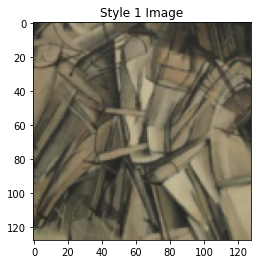

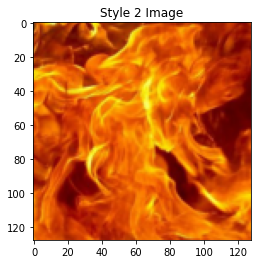

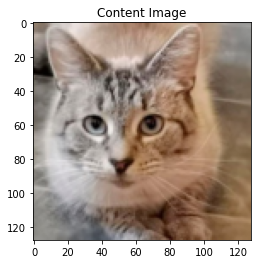

In [5]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка

plt.figure()
imshow(style_img, title='Style 1 Image')

plt.figure()
imshow(style2_img, title='Style 2 Image')

plt.figure()
imshow(content_img, title='Content Image')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

In [6]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input):
            self.loss = F.mse_loss(input, self.target)
            return input

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Матрица Грамма

In [7]:
def gram_matrix(input):
        batch_size , h, w, f_map_num = input.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)

        features = input.view(batch_size * h, w * f_map_num)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)

In [8]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something
        def forward(self, input):
            G = gram_matrix(input)
            self.loss = F.mse_loss(G, self.target)
            return input

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.


In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [10]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

In [11]:
content_layers_default = ['conv_4','conv_9']
style_layers_default = ['conv_1', 'conv_3', 'conv_5','conv_7', 'conv_9']
style2_layers_default = ['conv_2', 'conv_4', 'conv_6', 'conv_8', 'conv_10']

Определим предобученную модель

In [12]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [13]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style_img, style2_img, content_img,
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default,
                                   style2_layers=style2_layers_default, 
                               ):
        cnn = copy.deepcopy(cnn)
        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses = []
        style2_losses = []
        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)
            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)
            if name in style_layers:
                # add style 1 loss:
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style_loss)
                style_losses.append(style_loss)
            if name in style2_layers:
                # add style 2 loss:
                target_feature = model(style2_img).detach()
                style2_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(i), style2_loss)
                style2_losses.append(style2_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses, content_losses, style2_losses

In [14]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()],lr=1) 
        return optimizer

Дальше стандартный цикл обучения, но что это за closure?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss. Без нее ничего не получется так как у нас своя функция ошибки

In [15]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, style2_img, input_img, num_steps=500,
                        style1_weight=100000, style2_weight=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')
        model, style_losses, content_losses, style2_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style_img,style2_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:
            #print('0')
            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score = 0
                style2_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for s2 in style2_losses:
                    style2_score += s2.loss
                for cl in content_losses:
                    content_score += cl.loss
                #взвешивание ощибки
                style_score *= style1_weight
                style2_score *= style2_weight
                content_score *= content_weight

                loss = style_score + content_score + style2_score
                #loss = style_score + content_score 
                loss.backward(retain_graph=True)
                #loss.backward()
                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss : {:4f} Style2 Loss : {:4f} Content Loss: {:4f}'.format(
                        style_score.item(), style2_score.item(), content_score.item()))
                    #print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    #    style_score.item(), content_score.item()))
                    print()
                return style_score + content_score + style2_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)
        return input_img

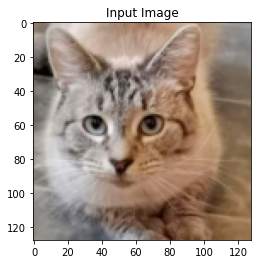

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 1439.059814 Style2 Loss : 1844.954712 Content Loss: 164.664459

run [100]:
Style Loss : 1253.322021 Style2 Loss : 1493.801025 Content Loss: 176.546646

run [150]:
Style Loss : 1182.613892 Style2 Loss : 1371.664673 Content Loss: 181.279297

run [200]:
Style Loss : 1151.276733 Style2 Loss : 1302.692627 Content Loss: 184.064758

run [250]:
Style Loss : 1135.127686 Style2 Loss : 1253.438599 Content Loss: 185.339767

run [300]:
Style Loss : 1125.144165 Style2 Loss : 1215.843262 Content Loss: 186.934311

run [350]:
Style Loss : 1116.096436 Style2 Loss : 1188.221436 Content Loss: 188.068832

run [400]:
Style Loss : 1112.265503 Style2 Loss : 1161.651001 Content Loss: 189.141083

run [450]:
Style Loss : 1110.102417 Style2 Loss : 1138.512451 Content Loss: 190.237350

run [500]:
Style Loss : 1108.599121 Style2 Loss : 1118.132446 Content Loss: 190.667938



In [16]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style2_img, input_img)

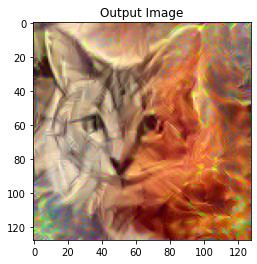

In [17]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()